In [1]:
# Install necessary libraries
!pip install -q autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.5/454.5 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 12.6 MB/s eta 0:0

Source: https://github.com/Worayot/Water-level-prediction

In [32]:
# Clone github repository
!rm -rf /content/Water-level-prediction
!git clone https://github.com/Worayot/Water-level-prediction

Cloning into 'Water-level-prediction'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 2), reused 12 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 969.26 KiB | 15.63 MiB/s, done.
Resolving deltas: 100% (2/2), done.


# **Introduction**
**Problem**


---


Water from water station "E98" and water station "M182" flows to water station "M7", which takes 2-3 days, causes it to raise its water level, which can lead to flood.

**Objective**

---


The objective is to find out what is the relationship of water volume of water station "E98", water station "M182" and water station "M7" and try to predict water volume at water station "M7" from the relationship.

**Data source**

---


Data is obtained from website "Lower Northeastern Region Hydrological Irrigation Center" (Link: http://hydro-4.rid.go.th/) can be found in "Hourly data" section (Red button below the title). The data was collected since 1st of August, 2561 which contains hourly data (most consistently collected at specific time at '6.00', '9.00', '12.00', '15.00' and '18.00' until now).


**Preparing Data**
The code below shows how we fetch the data of each water levels at diffent water stations using python requests library and save it in to csv files.

The data consists of following
- Date-Hours: The time that the three water stations collected the water levels data.
- M7: Water levels data (m^3) at water station M7.
- E98: Water levels data (m^3) at water station E98.
- M182: Water levels data (m^3) at water station M182.

In [3]:
# Import necessary library
import requests
from datetime import datetime, timedelta
import pandas as pd

# Set API key for fetching data
URL_HOURLY_DATA: str = 'https://hyd-app-db.rid.go.th/webservice/getGroupHourlyWaterLevelReportAllHLAD.ashx'

# Function for generating date column for the data frame
def generate_dates2(start_date: datetime):
    # Set end date to be current date
    end_date = datetime.now()

    # Change year format to Buddhist Era format
    end_date_be = end_date.replace(year=end_date.year + 543)

    # Collect data everyday
    delta = timedelta(days=1)

    # Instance list for storing dates
    dates: list = []
    current_date = start_date
    while current_date <= end_date_be:
        # Append the dates into the list
        dates.append(current_date.strftime('%d/%m/%Y'))
        current_date += delta
    return dates

# Function for setting payloads for API
def set_payload2(datetime: str) -> str:
    payload = {
        'DW[UtokID]': '4',
        'DW[BasinID]': '5',
        '_search': 'false',
        'DW[TimeCurrent]': datetime,
        'nd': '1731971088184',
        'rows': '1000',
        'page': '1',
        'sidx': 'indexhourly',
        'sord': 'asc'
    }

    return payload

# Function for fetching data by using API key and payloads
def fetch_hourly_data() -> object:
    M7_hourly_data: list = []
    M182_hourly_data: list = []
    E98_hourly_data: list = []
    date_data: list = []

    # Interested hourly data
    hours_list = ['6.00', '9.00', '12.00', '15.00', '18.00']

    # Start date of the first time data being collected
    dates = generate_dates2(datetime(2561, 8, 1))

    for date in dates:
        # Set new payload
        payload = set_payload2(date)
        try:
            # Use POST method
            response = requests.post(URL_HOURLY_DATA, data=payload)
            response.raise_for_status()  # Raise an exception for HTTP errors
            try:
                data = response.json()  # Try parsing the JSON response
            except ValueError as ve:
                print(f"Invalid JSON response for {date}: {response.content}")
                continue
        except requests.RequestException as e:
            print(f"Error fetching data for {date}: {e}")
            continue  # Skip this date if an error occurs

        # Ensure `data` is a dictionary and contains the 'rows' key
        if not isinstance(data, dict) or 'rows' not in data:
            print(f"Unexpected response structure for {date}: {data}")
            continue

        # Process rows if they exist
        for item in data.get('rows', []):
            if item.get('hourlytime') in hours_list:
                date_data.append(f"{date} {item.get('hourlytime', '***')}")
                M7_hourly_data.append(item.get('qvalues34', '***'))
                M182_hourly_data.append(item.get('qvalues28', '***'))
                E98_hourly_data.append(item.get('qvalues30', '***'))

    return M7_hourly_data, E98_hourly_data, M182_hourly_data, date_data

#! Comment to avoid rerunning.
# M7_hourly_data, E98_hourly_data, M182_hourly_data, date_data = fetch_hourly_data()

# # Save to .csv file
# hourly_data_df = pd.DataFrame(data={"Date-Hours": date_data, "M7": M7_hourly_data, "E98": E98_hourly_data, "M182": M182_hourly_data})
# hourly_data_df.to_csv("Hourly_water_level_data.csv")

The received data will then be manually trimmed, since it takes at most 3 days for the water to flow from water station "E98" and water station "M182" to water station "M7", the data of water station "E98" and water station "M182" will be shifted down 3 days to correctly match the data. The unused data will then be deleted and save the new data as a .csv file named "trimmed_hourly_data.csv" and use it for training the model where "M7" is value to be predicted or target variable and the features are "E98" and "M182".

**Note**

---


In this project, I have already prepared the necessary data so I will be commenting out the scripts for fetching the data to avoid spamming the request to the server if this jupiter file were to be reran. So I will move the prepared data to the content directory for easier uses.

In [4]:
# Move the files to content folder on colab
!mv /content/Water-level-prediction/trimed_hourly_data.csv /content/

# **Methodology and Approach**

In this project I will be using machine learning models as following:
- Random Forests Model
- Neural Network Model
- Autogluon Model

I will compare these three models by using MSE and R-squared to evaluate each models.
To understand the relationship between the water levels at the three stations. Machine learning models, particularly models like Random Forests and Neural Networks, are capable of uncovering non-linear and intricate relationships within data.

# **Data Preprocessing**

In [5]:
# Import Library
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Load the dataset
file_path = "trimed_hourly_data.csv"
df = pd.read_csv(file_path)
df

,Unnamed: 0,Date-Hours,M7,E98,M182
0,15,04/08/2561 6.00,1095,799,29.4
1,16,04/08/2561 9.00,1095,799,30
2,17,04/08/2561 12.00,1095,799,31.6
3,18,04/08/2561 15.00,1090,801.7,32.8
4,19,04/08/2561 18.00,1095,801.7,34.4
...,...,...,...,...,...
11485,11500,19/11/2567 6.00,257,121.1,197.8
11486,11501,19/11/2567 9.00,260.5,121.1,192.7
11487,11502,19/11/2567 12.00,264,121.1,187.6
11488,11503,19/11/2567 15.00,267.5,121.1,180.8


In [6]:
# Drop unused columns
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('Date-Hours', axis=1)
df['M7'] = pd.to_numeric(df['M7'], errors='coerce')
df = df.dropna(subset=['M7'])
df['M182'] = pd.to_numeric(df['M182'], errors='coerce')
df = df.dropna(subset=['M182'])
df['E98'] = pd.to_numeric(df['E98'], errors='coerce')
df = df.dropna(subset=['E98'])

df

,M7,E98,M182
0,1095.0,799.0,29.4
1,1095.0,799.0,30.0
2,1095.0,799.0,31.6
3,1090.0,801.7,32.8
4,1095.0,801.7,34.4
...,...,...,...
11485,257.0,121.1,197.8
11486,260.5,121.1,192.7
11487,264.0,121.1,187.6
11488,267.5,121.1,180.8


**Data Visualiztion**
The following graphs will provide you what does the data looks like, the graphs consist of the following relationships:
- E98 vs M7
- M182 vs M7

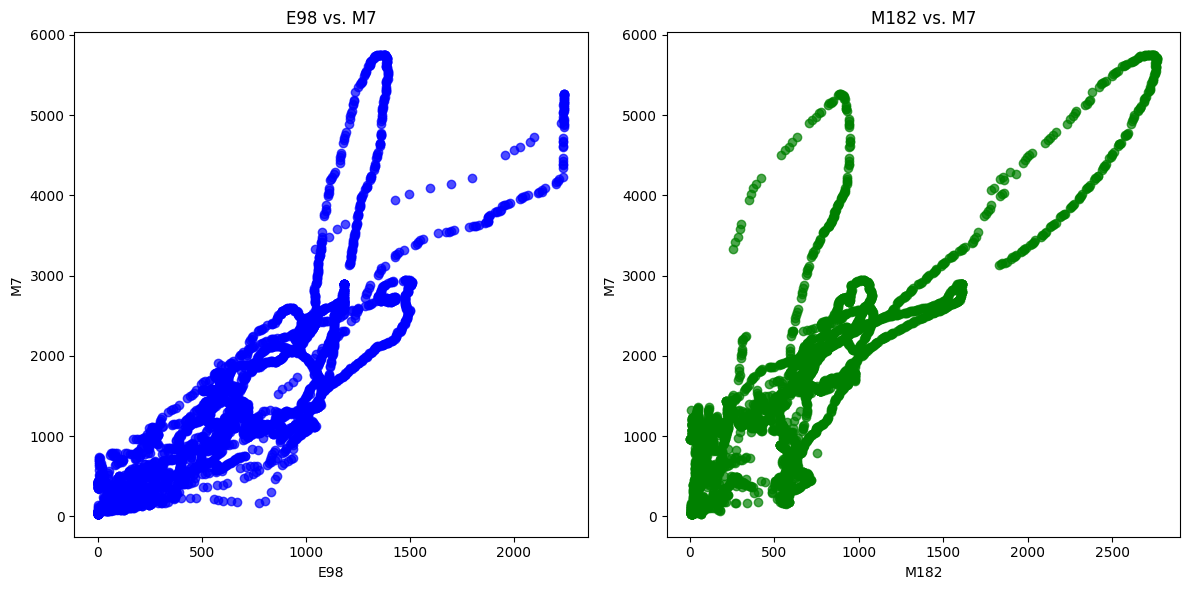

In [7]:
# Instance features and target variable
X = df[['E98', 'M182']]
y = df[['M7']]

# Plot E98 vs. M7
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, first plot)
plt.scatter(df['E98'], df['M7'], color='blue', alpha=0.7)
plt.title('E98 vs. M7')
plt.xlabel('E98')
plt.ylabel('M7')

# Plot M182 vs. M7
plt.subplot(1, 2, 2)  # Second plot
plt.scatter(df['M182'], df['M7'], color='green', alpha=0.7)
plt.title('M182 vs. M7')
plt.xlabel('M182')
plt.ylabel('M7')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


The data might have outliers, the filter them out, I will use the IQR method, by seperating data into quartiles, we can easily filter out the outliers those are outside of the quartile ranges.

Correlation Matrix:
E98     0.868164
M182    0.873718
M7      1.000000
Name: M7, dtype: float64
Unfiltered data shape: (4214, 2), (4214, 1)
Filtered data shape: (3996, 2), (3996, 1)


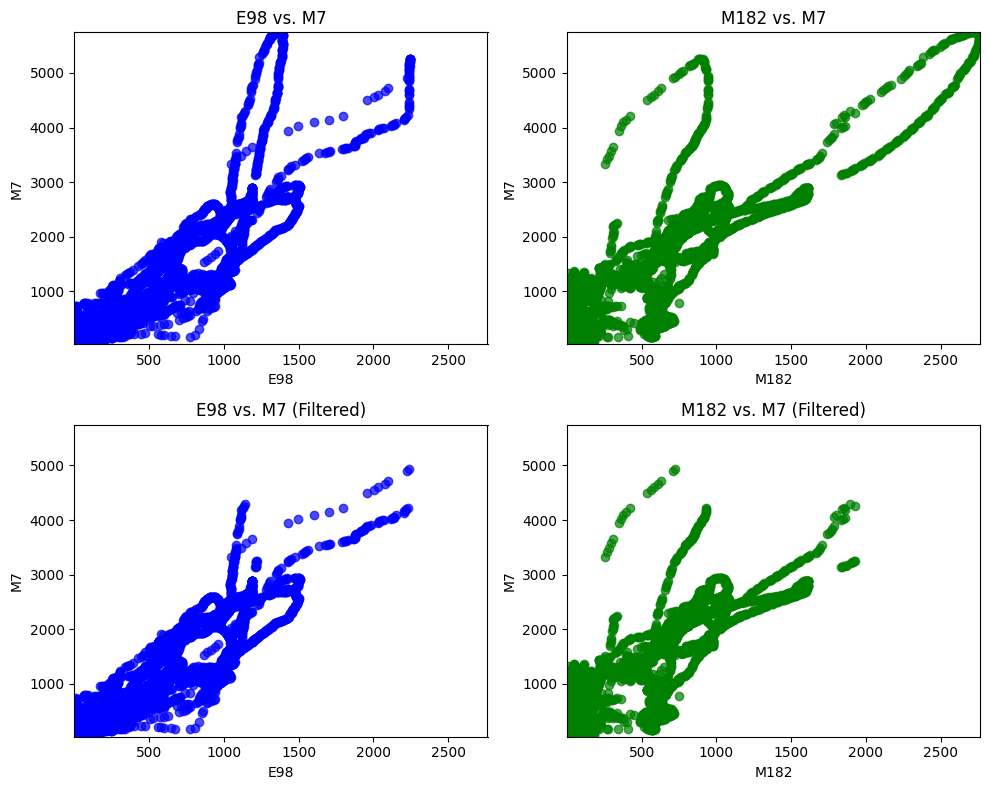

In [8]:
# Compute the correlation matrix
print("Correlation Matrix:")
correlation_matrix = pd.concat([X, y], axis=1).corr()
print(correlation_matrix['M7'])

# Remove outliers using IQR method
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
outlier_mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
X_filtered = X[outlier_mask]
y_filtered = y.loc[outlier_mask]

# Convert y and y_filtered to Series for min/max calculations
y_series = y.iloc[:, 0]
y_filtered_series = y_filtered.iloc[:, 0]

print(f"Unfiltered data shape: {X.shape}, {y.shape}")
print(f"Filtered data shape: {X_filtered.shape}, {y_filtered.shape}")

# Define consistent limits
x_limit = [min(X['E98'].min(), X['M182'].min()), max(X['E98'].max(), X['M182'].max())]
y_limit = [min(y_series.min(), y_filtered_series.min()), max(y_series.max(), y_filtered_series.max())]

plt.figure(figsize=(10, 8))

# First subplot
plt.subplot(2, 2, 1)
plt.scatter(X['E98'], y_series, color='blue', alpha=0.7)
plt.title('E98 vs. M7')
plt.xlabel('E98')
plt.ylabel('M7')
plt.xlim(x_limit)
plt.ylim(y_limit)

# Second subplot
plt.subplot(2, 2, 2)
plt.scatter(X['M182'], y_series, color='green', alpha=0.7)
plt.title('M182 vs. M7')
plt.xlabel('M182')
plt.ylabel('M7')
plt.xlim(x_limit)
plt.ylim(y_limit)

# Third subplot
plt.subplot(2, 2, 3)
plt.scatter(X_filtered['E98'], y_filtered_series, color='blue', alpha=0.7)
plt.title('E98 vs. M7 (Filtered)')
plt.xlabel('E98')
plt.ylabel('M7')
plt.xlim(x_limit)
plt.ylim(y_limit)

# Fourth subplot
plt.subplot(2, 2, 4)
plt.scatter(X_filtered['M182'], y_filtered_series, color='green', alpha=0.7)
plt.title('M182 vs. M7 (Filtered)')
plt.xlabel('M182')
plt.ylabel('M7')
plt.xlim(x_limit)
plt.ylim(y_limit)

# Adjust layout
plt.tight_layout()
plt.show()


**Preparing data for model training**

---

I will use train_test_split method to do train-test split and scale the data using StandardScaler method. Both of these methods are from python sklearn library.

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42
)

print(f"Train/Test split: {X_train.shape}, {X_test.shape}")

# Scale the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), columns=X_test.columns, index=X_test.index
)

Train/Test split: (3196, 2), (800, 2)


# **Model training**
**Choosing models**

---
Here, I will choose two models consists of Random Forest and Neural Network and will be comparing those two models using MSE and R-squared method.


In [17]:
from sklearn.neural_network import MLPRegressor
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from IPython.display import display

# Assuming X_train_scaled, X_test_scaled, y_train, y_test are already defined

# Initialize models and feature sets
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Neural Network': MLPRegressor(random_state=42, max_iter=1000)
}

feature_sets = {
    'All Features': X_train_scaled.columns, # Use scaled column names
    'Top 2 Features': X_train_scaled.columns[:2] # Changed to Top 2 as per your initial feature selection
}

# List to store results
results_list = []

for model_name, model in models.items():
    for feature_set_name, features in feature_sets.items():
        X_train_subset = X_train_scaled[features]
        X_test_subset = X_test_scaled[features]

        # Calculate Cross-Validation Scores
        cv_mse_scores = cross_val_score(
            model, X_train_subset, y_train.values.ravel(), cv=5, scoring='neg_mean_squared_error'
        )
        avg_cv_mse = -cv_mse_scores.mean()

        cv_r2_scores = cross_val_score(
             model, X_train_subset, y_train.values.ravel(), cv=5, scoring='r2'
        )
        avg_cv_r2 = cv_r2_scores.mean()

        # Train the model on the full training data subset
        model.fit(X_train_subset, y_train.values.ravel())

        # Make predictions on the test data subset
        y_pred = model.predict(X_test_subset)

        # Evaluate on the test set
        test_mse = mean_squared_error(y_test, y_pred)
        test_r2 = r2_score(y_test, y_pred)

        # Append results to the list
        results_list.append({
            'Model': model_name,
            'Feature Set': feature_set_name,
            'Cross-Validation MSE': avg_cv_mse,
            'Cross-Validation R-squared': avg_cv_r2,
            'Test MSE': test_mse,
            'Test R-squared': test_r2
        })

        print(f"{model_name} with {feature_set_name}:")
        print(f"  Cross-Validation MSE: {avg_cv_mse:.2f}")
        print(f"  Cross-Validation R-squared: {avg_cv_r2:.2f}")
        print(f"  Test MSE: {test_mse:.2f}")
        print(f"  Test R-squared: {test_r2:.2f}")
        print("-" * 20)


# Create the pandas DataFrame
results_df = pd.DataFrame(results_list)

# Display the DataFrame
display(results_df)

Random Forest with All Features:
  Cross-Validation MSE: 23711.33
  Cross-Validation R-squared: 0.97
  Test MSE: 16606.64
  Test R-squared: 0.98
--------------------
Random Forest with Top 2 Features:
  Cross-Validation MSE: 23711.33
  Cross-Validation R-squared: 0.97
  Test MSE: 16606.64
  Test R-squared: 0.98
--------------------


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

Neural Network with All Features:
  Cross-Validation MSE: 98091.98
  Cross-Validation R-squared: 0.89
  Test MSE: 94353.92
  Test R-squared: 0.89
--------------------


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

Neural Network with Top 2 Features:
  Cross-Validation MSE: 98091.98
  Cross-Validation R-squared: 0.89
  Test MSE: 94353.92
  Test R-squared: 0.89
--------------------


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,Feature Set,Cross-Validation MSE,Cross-Validation R-squared,Test MSE,Test R-squared
0,Random Forest,All Features,23711.334193,0.973407,16606.643789,0.980959
1,Random Forest,Top 2 Features,23711.334193,0.973407,16606.643789,0.980959
2,Neural Network,All Features,98091.979150,0.889913,94353.918064,0.891816
3,Neural Network,Top 2 Features,98091.979150,0.889913,94353.918064,0.891816


**Conclusion**


---


Based on the results of comparing the two machine learning models by using two different feature sets, the Random Forest model, using either "All Features" or "Top 2 Features", is the best performing model for the dataset, with a Test MSE of approximately 16606.64 and a Test R-squared of approximately 0.98.

**Training model using Automodel: Autogluon**

In [21]:
# Import AutoGluon
from autogluon.tabular import TabularDataset, TabularPredictor

train_data = TabularDataset(pd.concat([X_train_scaled, y_train], axis=1))

# Specify the target column
label = 'M7'

# Initialize TabularPredictor
predictor = TabularPredictor(label=label, problem_type='regression', path='autogluon_models')

# Train the predictor
predictor.fit(train_data)

# Make predictions on the test set
test_data = TabularDataset(pd.concat([X_test_scaled, y_test], axis=1))
y_pred_autogluon = predictor.predict(test_data)

# Evaluate the AutoGluon model
test_mse_autogluon = mean_squared_error(y_test, y_pred_autogluon)
test_r2_autogluon = r2_score(y_test, y_pred_autogluon)

print(f"AutoGluon Test MSE: {test_mse_autogluon:.2f}")
print(f"AutoGluon Test R-squared: {test_r2_autogluon:.2f}")

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       10.10 GB / 12.67 GB (79.7%)
Disk Space Avail:   70.19 GB / 112.64 GB (62.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference s

[1000]	valid_set's rmse: 223.98
[2000]	valid_set's rmse: 216.209
[3000]	valid_set's rmse: 211.496
[4000]	valid_set's rmse: 207.979
[5000]	valid_set's rmse: 205.839
[6000]	valid_set's rmse: 203.539
[7000]	valid_set's rmse: 201.506
[8000]	valid_set's rmse: 199.888
[9000]	valid_set's rmse: 197.863
[10000]	valid_set's rmse: 196.047


	-196.0428	 = Validation score   (-root_mean_squared_error)
	2.97s	 = Training   runtime
	0.44s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 151.48
[2000]	valid_set's rmse: 149.386


	-149.0924	 = Validation score   (-root_mean_squared_error)
	1.44s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-147.6885	 = Validation score   (-root_mean_squared_error)
	1.49s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: CatBoost ...
	-157.9656	 = Validation score   (-root_mean_squared_error)
	14.74s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-141.7045	 = Validation score   (-root_mean_squared_error)
	0.82s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-247.8244	 = Validation score   (-root_mean_squared_error)
	2.3s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-159.7065	 = Validation score   (-root_mean_squared_error)
	0.61s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-167.9539	 = Validation score   (-root_mean_squared_error)
	122.95s	 = Training   runtime
	0.01s	 = V

AutoGluon Test MSE: 17633.27
AutoGluon Test R-squared: 0.98


**Conclusion based on Model Evaluation**

---


Both the Random Forest model and the AutoGluon model achieved very similar and high R-squared values around 0.98 on the test set, indicating that both models are capable of explaining a significant portion of the variance in the M7 water level.

The Random Forest model slightly outperformed the AutoGluon model in terms of Test MSE (16606.64 vs 17633.27), suggesting it had slightly smaller prediction errors on average on this specific test split. However, the difference is relatively small, and both models provide a very good fit to the data.

# **Visualization**

**Re-train the random forest model**

In [26]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd # Make sure pandas is imported
import numpy as np # Make sure numpy is imported

random_forest_model = RandomForestRegressor(random_state=42)

# Train the model on the scaled training data
if isinstance(y_train, pd.DataFrame):
    y_train_for_fit = y_train.values.ravel()
elif isinstance(y_train, pd.Series):
    y_train_for_fit = y_train.values
else:
    y_train_for_fit = y_train # Assuming it's already a NumPy array

random_forest_model.fit(X_train_scaled, y_train_for_fit)

# Make predictions on the scaled test data
y_pred = random_forest_model.predict(X_test_scaled)

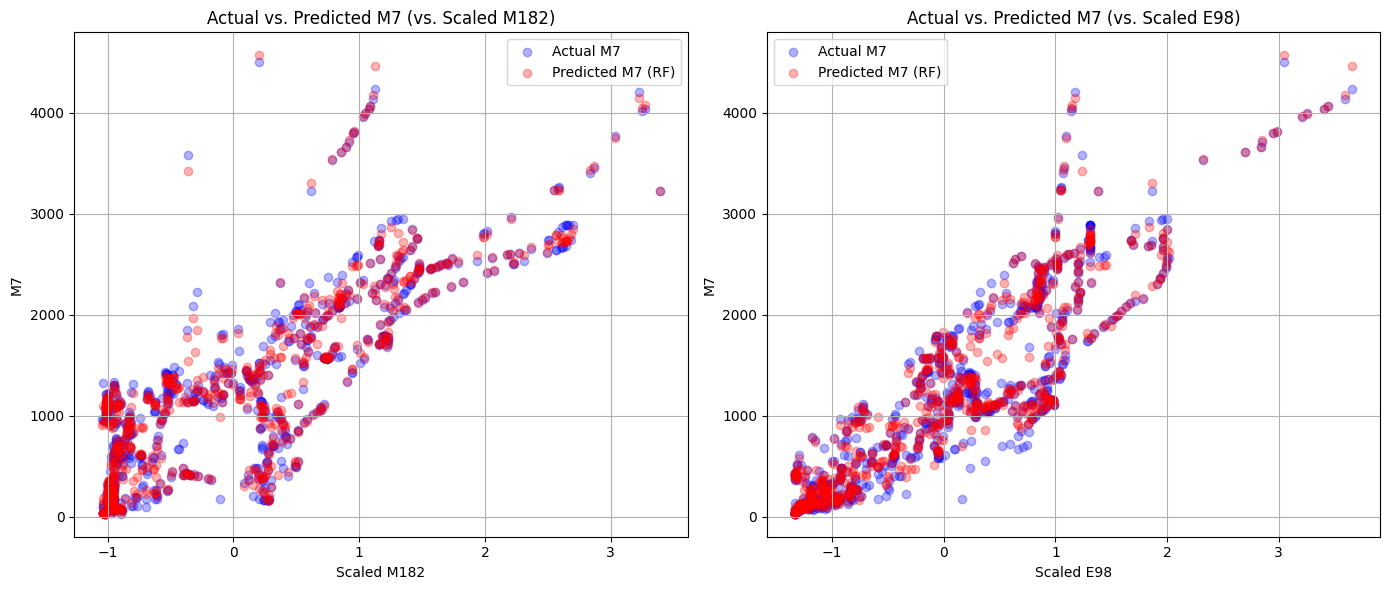

In [31]:
import matplotlib.pyplot as plt
import pandas as pd # Make sure pandas is imported

# Assuming y_test, y_pred (from your trained Random Forest model), and X_test_scaled are available

# Ensure y_test and y_pred are in a compatible format (e.g., pandas Series or NumPy arrays)
if isinstance(y_test, pd.DataFrame):
    y_test_series = y_test.iloc[:, 0]
else:
    y_test_series = y_test # Assuming it's already a Series or NumPy array

# Ensure y_pred is a NumPy array or Series
if isinstance(y_pred, pd.Series):
    y_pred_array = y_pred.values
elif isinstance(y_pred, pd.DataFrame):
     y_pred_array = y_pred.iloc[:, 0].values
else:
    y_pred_array = y_pred # Assuming it's already a NumPy array


# Create a figure with two subplots (1 row, 2 columns)
plt.figure(figsize=(14, 6)) # Adjust figure size as needed

# Plot Actual vs. Predicted for M182 vs. M7
plt.subplot(1, 2, 1)
plt.scatter(X_test_scaled['M182'], y_test_series, color='blue', alpha=0.3, label='Actual M7')
plt.scatter(X_test_scaled['M182'], y_pred_array, color='red', alpha=0.3, label='Predicted M7 (RF)') # Use y_pred
plt.title('Actual vs. Predicted M7 (vs. Scaled M182)')
plt.xlabel('Scaled M182')
plt.ylabel('M7')
plt.legend()
plt.grid(True)

# Plot Actual vs. Predicted for E98 vs. M7
plt.subplot(1, 2, 2)
plt.scatter(X_test_scaled['E98'], y_test_series, color='blue', alpha=0.3, label='Actual M7')
plt.scatter(X_test_scaled['E98'], y_pred_array, color='red', alpha=0.3, label='Predicted M7 (RF)') # Use y_pred
plt.title('Actual vs. Predicted M7 (vs. Scaled E98)')
plt.xlabel('Scaled E98')
plt.ylabel('M7')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the plots
plt.show()